# Simple Classifier Convolutional Neural Network
## In this notebook I'm going to Download, Preprocess, Model and train a Simple Classifier CNN.

## importing Libraries
1. `torch, torch.nn, torch.optim, torch.utils.data` and `torchvision` to create model and preprocessors
2. `numpy` to change image types if needed
3. `matplotlib` to plot and show the Data and loss curves
4. `os` to count cpu
5. `requests` to download dataset
6. `zipfile` to unzip dataset
7. `pathlib` to control and work with the directories

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import zipfile
from pathlib import Path
from PIL import Image

## Download Dataset
This dataset contains 3 classes of 600 food images, `Pizza`, `Steak` and `Sushi`.

* 450 train images
* 150 test images

In [ ]:
data_path  = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} already exists...Stop Downloading")
else:
  print("Downloading the data...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download the dataset
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    data = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    f.write(data.content)

  # Unzipping the dataset
  print("Unzipping the files...")
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_file:
    zip_file.extractall(image_path)

print("Process finished successfully...")

Unzipping the files...
Process finished successfully...


In [ ]:
def walk_through_dir(dir_path):
  """Walk through directory path and returning its contents."""
  for dirpath, dirnames, dirfiles in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(dirfiles)} files in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 files in data/pizza_steak_sushi
There are 3 directories and 0 files in data/pizza_steak_sushi/train
There are 0 directories and 154 files in data/pizza_steak_sushi/train/pizza
There are 0 directories and 146 files in data/pizza_steak_sushi/train/steak
There are 0 directories and 150 files in data/pizza_steak_sushi/train/sushi
There are 3 directories and 0 files in data/pizza_steak_sushi/test
There are 0 directories and 46 files in data/pizza_steak_sushi/test/pizza
There are 0 directories and 58 files in data/pizza_steak_sushi/test/steak
There are 0 directories and 46 files in data/pizza_steak_sushi/test/sushi


In [ ]:
import random
def plot_images(image_paths, seed=None):
    # Set seed
    if seed:
        random.seed(seed)

    # Create figure
    plt.figure(figsize=(16, 9))

    # Get random images
    random_samples = random.sample(list(image_paths.glob("*/*/*.jpg")), k=5)

    for i, image in enumerate(random_samples):  # Added enumerate to get index
        img = Image.open(image)
        img_class = image.parent.stem  # Removed parentheses

        # Plot the image
        plt.subplot(1, 5, i+1)  # Using loop index instead of image
        plt.imshow(img)
        plt.title(img_class)  # Added title to show the class
        plt.axis(False)

    plt.show()  # Show the plot

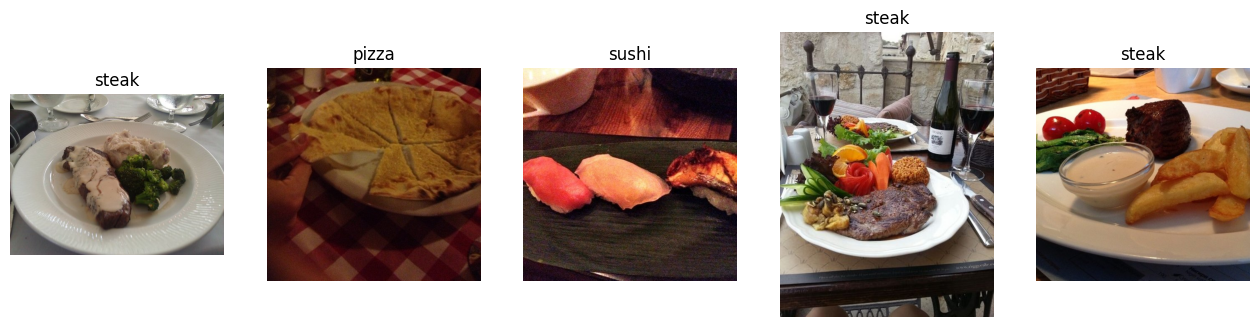

In [ ]:
plot_images(image_path)

## Creating Torch Dataset

In [ ]:
train_dir = image_path / "train"
test_dir  = image_path / "test"

transformer = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transformer)
test_dataset  = datasets.ImageFolder(root=test_dir , transform=transformer)

print(f"We have {len(train_dataset)} images to train our model, and {len(test_dataset)} images to test our model.")

We have 450 images to train our model, and 150 images to test our model.


In [ ]:
img_sample = train_dataset[0][0]
lbl_sample = train_dataset[0][1]

"First image shape:", img_sample.shape, "First image label:", lbl_sample

('First image shape:', torch.Size([3, 128, 128]), 'First image label:', 0)

## Creating DataLoaders

In [ ]:
num_workers = os.cpu_count()

batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset, shuffle=True , num_workers=num_workers, batch_size=batch_size)
test_dataloader  = DataLoader(dataset=test_dataset , shuffle=False, num_workers=num_workers, batch_size=batch_size)

print(f"We have {len(train_dataloader)} batches of {batch_size} in train dataloader.")
print(f"We have {len(test_dataloader)}  batches of {batch_size} in test  dataloader.")

We have 15 batches of 32 in train dataloader.
We have 5  batches of 32 in test  dataloader.


## Create Our Model

**Model info:**
We have 3 sequential blocks

First two sequential blocks:
1. Each block has 3 Convolutional layers.
2. Each block has 1 ReLU layer after each Convolutional layer.
3. Each block has 1 MaxPool layer after all layers.

Then we have a classifier(fully connected) block:

In this block we have a Flatten layer then two Linear layers.
1. 14580 --> 100.
1. 100   --> 3. **Because we have 3 classes**



In [ ]:
!pip install torchinfo

In [ ]:
# Setting the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class Classifier(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*27*27, out_features=100),
        nn.Linear(in_features=100, out_features=output_shape)
    )
  def forward(self, x):
    # print(f"Shape before conv 1: {x.shape}")
    x = self.conv_block_1(x)
    # print(f"Shape after conv 1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Shape after conv 2: {x.shape}")
    x = self.classifier(x)

    return x

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = Classifier(input_shape=3,   # Number of color channels of our images.
                   hidden_units=20, # Number of filters we want to apply on each image.
                   output_shape=len(train_dataset.classes) # Number of classes.
                   ).to(device)

In [ ]:
# Dsiplaying our model informations
from torchinfo import summary
summary(model=model, input_size=torch.rand(1, 3, 128, 128).shape)

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [1, 3]                    --
├─Sequential: 1-1                        [1, 20, 61, 61]           --
│    └─Conv2d: 2-1                       [1, 20, 126, 126]         560
│    └─ReLU: 2-2                         [1, 20, 126, 126]         --
│    └─Conv2d: 2-3                       [1, 20, 124, 124]         3,620
│    └─ReLU: 2-4                         [1, 20, 124, 124]         --
│    └─Conv2d: 2-5                       [1, 20, 122, 122]         3,620
│    └─ReLU: 2-6                         [1, 20, 122, 122]         --
│    └─MaxPool2d: 2-7                    [1, 20, 61, 61]           --
├─Sequential: 1-2                        [1, 20, 27, 27]           --
│    └─Conv2d: 2-8                       [1, 20, 59, 59]           3,620
│    └─ReLU: 2-9                         [1, 20, 59, 59]           --
│    └─Conv2d: 2-10                      [1, 20, 57, 57]           3,620
│ 

In [ ]:
# Set Criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

## Train Model

In [ ]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

def train(model: torch.nn.Module, criterion: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          train_data: torch.utils.data.DataLoader,
          test_data: torch.utils.data.DataLoader,
          epochs=5,
          device="cpu",
          ):

  model_results = {
        'train_loss' : [],
        'train_acc'  : [],
        'test_loss'  : [],
        'test_acc'   : [],
        "train_time": 0
  }

  start_train_time = timer()

  for epoch in tqdm(range(epochs)):
    print(f"\nEpoch {epoch}\n--------------------")

    # Set the model on train mode.
    model.train()

    train_loss, train_acc = 0, 0
    test_loss , test_acc  = 0, 0

    for batch, (X, y) in enumerate(train_data):

      # 1. Send data into device.
      X, y = X.to(device), y.to(device)

      # 2. Pass data through the model.
      y_pred = model(X)

      # 3. Calculate the model error.
      loss = criterion(y_pred, y)
      train_loss += loss.item()

      # 4. optimizer zero grad.
      optimizer.zero_grad()

      # 5. loss backward.
      loss.backward()

      # 6. optimizer step.
      optimizer.step()

      # 7. Calculate the output.
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

    train_loss /= len(train_data)
    train_acc  /= len(train_data)

    # Test phase
    model.eval()
    with torch.inference_mode():
      for batch, (X, y) in enumerate(test_data):
        # 1. Send data into device.
        X, y = X.to(device), y.to(device)

        # 2. Pass data through the model.
        test_pred = model(X)

        # 3. Calculate the model error.
        loss = criterion(test_pred, y)
        test_loss += loss.item()

        # 4. Calculate the output.
        test_pred_classes = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
        test_acc += (test_pred_classes == y).sum().item()/len(test_pred_classes)

      test_loss /= len(test_data)
      test_acc  /= len(test_data)

    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")
    print(f"Test loss : {train_loss:.4f} | Test accuracy : {test_acc:.4f}")

    model_results["train_loss"].append(train_loss)
    model_results["train_acc"].append(train_acc)
    model_results["test_loss"].append(test_loss)
    model_results["test_acc"].append(test_acc)

  end_train_time = timer()
  total_train_time = end_train_time - start_train_time
  print(f"Total train time: {total_train_time:.4f} seconds" )
  return model_results

In [ ]:
device

'cuda'


In [ ]:
model_results = train(model=model, criterion=criterion,
      optimizer=optimizer,
      train_data=train_dataloader,
      test_data=test_dataloader,
      epochs=5,
      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 0
--------------------
Train loss: 1.1301 | Train accuracy: 0.3271
Test loss : 1.1301 | Test accuracy : 0.4437

Epoch 1
--------------------
Train loss: 1.1011 | Train accuracy: 0.4000
Test loss : 1.1011 | Test accuracy : 0.3937

Epoch 2
--------------------
Train loss: 1.0544 | Train accuracy: 0.4083
Test loss : 1.0544 | Test accuracy : 0.5085

Epoch 3
--------------------
Train loss: 0.9662 | Train accuracy: 0.4646
Test loss : 0.9662 | Test accuracy : 0.5119

Epoch 4
--------------------
Train loss: 0.9263 | Train accuracy: 0.5437
Test loss : 0.9263 | Test accuracy : 0.4869
Total train time: 16.9368 seconds


## Plot The Loss And Accuracy Curves

In [ ]:
def plot_loss_and_acc(model_results: dict):

  train_loss = model_results["train_loss"]
  train_acc = model_results["train_acc"]
  test_loss = model_results["test_loss"]
  test_acc = model_results["test_acc"]

  epochs = range(len(train_loss))

  plt.figure(figsize=(16, 8))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label="Train loss")
  plt.plot(epochs, test_loss , label="Test loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label="Train accuracy")
  plt.plot(epochs, test_acc, label="Test accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

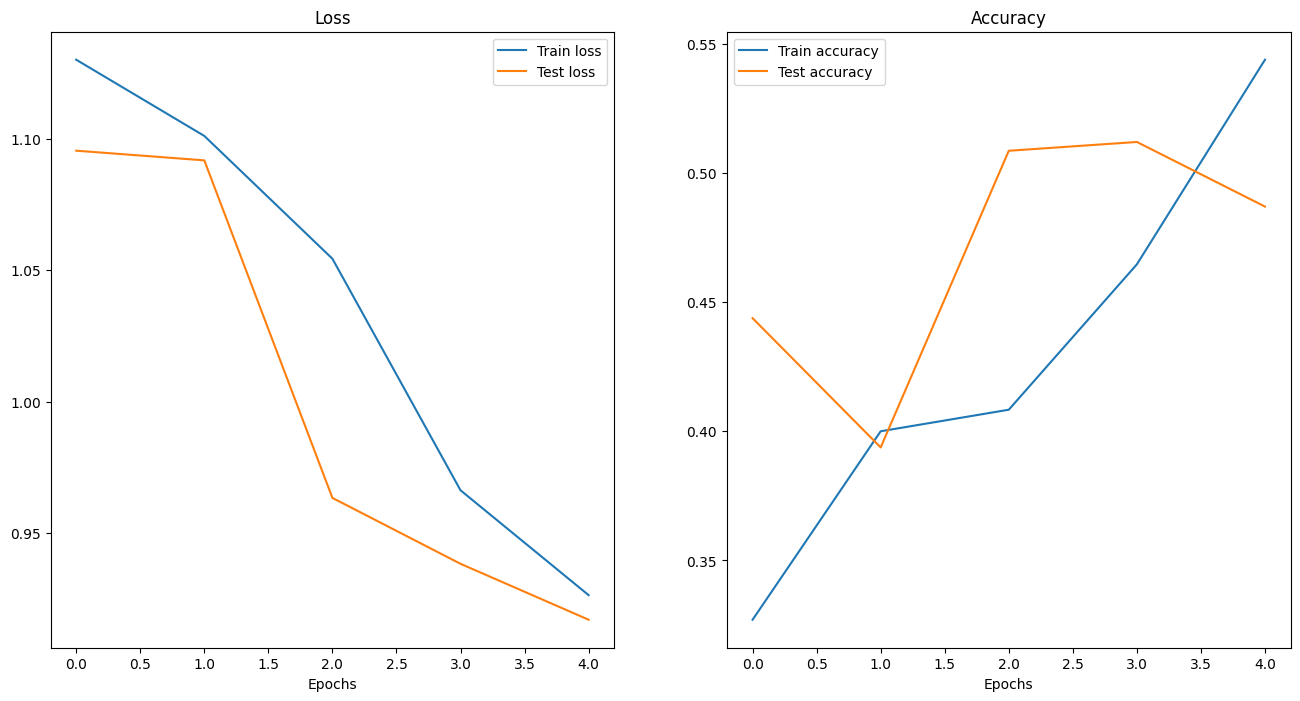

In [ ]:
plot_loss_and_acc(model_results)

## Data Augmentation
Below we are going to
1. Augment our dataset.
2. Combine the augmented data with simple data.
3. Then train a new instance of model with combined data.

In [ ]:
from torch.utils.data import ConcatDataset

# Create new transformer
transformer_aug = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

print("Length simple dataset: ", len(train_dataset))

# Create augmented dataset
train_dataset_augmented = datasets.ImageFolder(root=train_dir, transform=transformer_aug)
print("Length augmented dataset: ", len(train_dataset_augmented))

# Combine simple dataset with augmented dataset
combined_datasets = ConcatDataset([train_dataset, train_dataset_augmented])
print("Length combined datasets: ", len(combined_datasets))

# Create dataloader
train_dataloader_augmented = DataLoader(dataset=combined_datasets, shuffle=True, num_workers=num_workers, batch_size=batch_size)

Length simple dataset:  450
Length augmented dataset:  450
Length combined datasets:  900


In [ ]:
# Create new instance from Classifier
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = Classifier(input_shape=3,   # Number of color channels of our images.
                   hidden_units=20, # Number of filters we want to apply on each image.
                   output_shape=len(train_dataset.classes) # Number of classes.
                   ).to(device)

In [ ]:
# Set Criterion
criterion_2 = nn.CrossEntropyLoss()

# Set optimizer
optimizer_2 = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

In [ ]:
device

'cpu'

In [ ]:
model_2_results = train(model=model_2, criterion=criterion_2,
      optimizer=optimizer_2,
      train_data=train_dataloader_augmented,
      test_data=test_dataloader,
      epochs=5,
      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 0
--------------------
Train loss: 1.1141 | Train accuracy: 0.3502
Test loss : 1.1141 | Test accuracy : 0.3625

Epoch 1
--------------------
Train loss: 1.1017 | Train accuracy: 0.3211
Test loss : 1.1017 | Test accuracy : 0.3500

Epoch 2
--------------------
Train loss: 1.0980 | Train accuracy: 0.3233
Test loss : 1.0980 | Test accuracy : 0.3472

Epoch 3
--------------------
Train loss: 1.0897 | Train accuracy: 0.4300
Test loss : 1.0897 | Test accuracy : 0.4313

Epoch 4
--------------------
Train loss: 1.0281 | Train accuracy: 0.4623
Test loss : 1.0281 | Test accuracy : 0.5597
Total train time: 273.4033 seconds


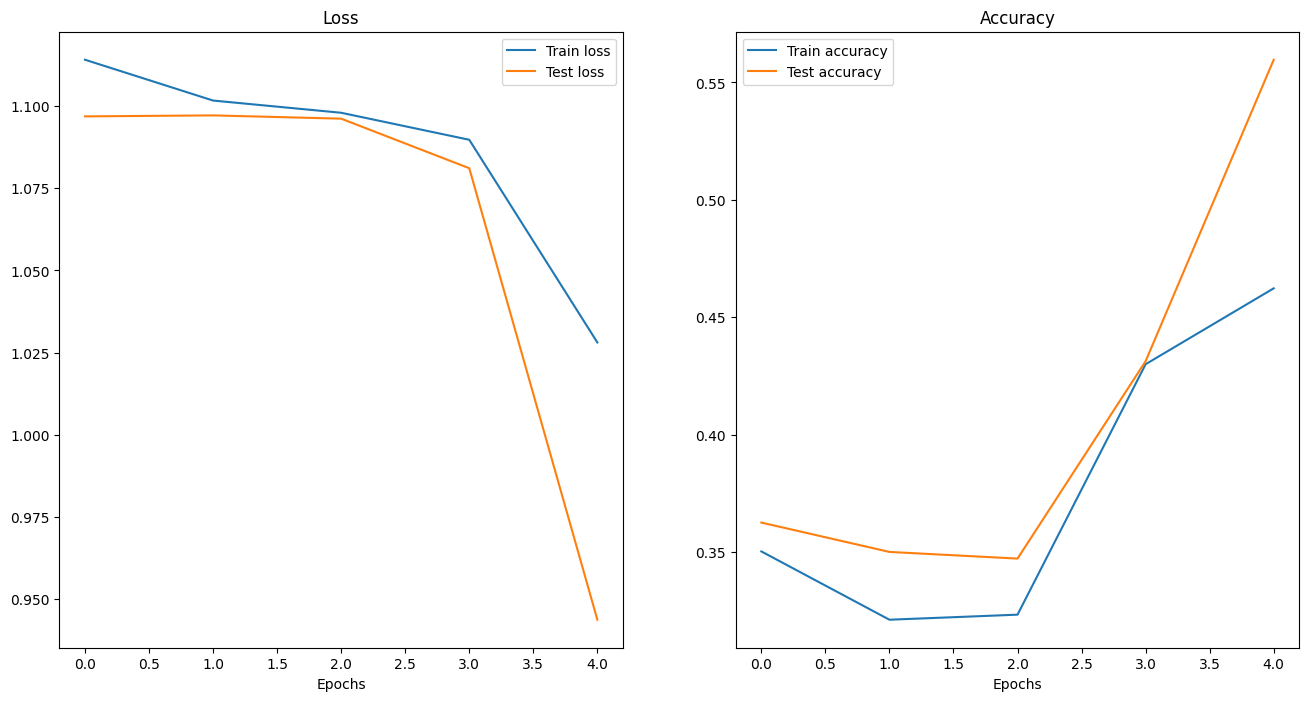

In [ ]:
plot_loss_and_acc(model_2_results)